In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from tqdm import tqdm
from random import randint

Using TensorFlow backend.


In [3]:
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_CHANNELS = 1
BATCH_SIZE = 128
EPOCHS = 200

In [4]:
def load_data():
    (x_train, _), (x_test, _) = mnist.load_data()
    x_train = x_train / 255.
    x_train = np.expand_dims(x_train, axis = 3)
    x_test = x_test / 255.
    x_test = np.expand_dims(x_test, axis = 3)
    return x_train, x_test

In [5]:
x_train, x_test = load_data()
x_train.shape, x_test.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28, 1), (10000, 28, 28, 1))

In [6]:
def build_autoencoder(image_width, image_height, image_channels):
    input_placeholder = Input(shape = (image_width, image_height, image_channels), name = 'Input')
    
    # Encoding
    encoded = Conv2D(16, (3, 3), activation = 'relu', padding = 'same', name = 'Encoding_Conv_Layer_1')(input_placeholder)
    encoded = MaxPooling2D((2, 2), padding = 'same', name = 'Encoding_Pool_Layer_1')(encoded)
    encoded = Conv2D(8, (3, 3), activation = 'relu', padding = 'same', name = 'Encoding_Conv_Layer_2')(encoded)
    encoded = MaxPooling2D((2, 2), padding = 'same', name = 'Encoding_Pool_Layer_2')(encoded)
    encoded = Conv2D(8, (3, 3), activation = 'relu', padding = 'same', name = 'Encoding_Conv_Layer_3')(encoded)
    encoded = MaxPooling2D((2, 2), padding = 'same', name = 'Encoding_Pool_Layer_3')(encoded)
    
    # Decoding
    decoded = Conv2D(8, (3, 3), activation = 'relu', padding = 'same', name = 'Decoding_Conv_Layer_1')(encoded)
    decoded = UpSampling2D((2, 2), name = 'Decoding_Upsampling_Layer_1')(decoded)
    decoded = Conv2D(8, (3, 3), activation = 'relu', padding = 'same', name = 'Decoding_Conv_Layer_2')(decoded)
    decoded = UpSampling2D((2, 2), name = 'Decoding_Upsampling_Layer_2')(decoded)
    decoded = Conv2D(16, (3, 3), activation = 'relu', name = 'Decoding_Conv_Layer_3')(decoded)
    decoded = UpSampling2D((2, 2), name = 'Decoding_Upsampling_Layer_3')(decoded)
    decoded = Conv2D(1, (3, 3), activation = 'relu', padding = 'same', name = 'Decoding_Conv_Layer_Final')(decoded)
    
    # Encoder
    encoder = Model(input_placeholder, encoded, name = 'Encoder')
    
    # Autoencoder
    autoencoder = Model(input_placeholder, decoded, name = 'Autoencoder')
    
    # Decoder
    encoded_input = Input(shape = (4, 4, 8, ))
    decoder_layer_1 = autoencoder.layers[-7]
    decoder_layer_2 = autoencoder.layers[-6]
    decoder_layer_3 = autoencoder.layers[-5]
    decoder_layer_4 = autoencoder.layers[-4]
    decoder_layer_5 = autoencoder.layers[-3]
    decoder_layer_6 = autoencoder.layers[-2]
    decoder_layer_7 = autoencoder.layers[-1]
    decoder = decoder_layer_1(encoded_input)
    decoder = decoder_layer_2(decoder)
    decoder = decoder_layer_3(decoder)
    decoder = decoder_layer_4(decoder)
    decoder = decoder_layer_5(decoder)
    decoder = decoder_layer_6(decoder)
    decoder = decoder_layer_7(decoder)
    final_decoder = Model(encoded_input, decoder, name = 'Decoder')
    
    autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')
    
    return encoder, final_decoder, autoencoder

In [7]:
encoder, decoder, autoencoder = build_autoencoder(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
Encoding_Conv_Layer_1 (Conv2 (None, 28, 28, 16)        160       
_________________________________________________________________
Encoding_Pool_Layer_1 (MaxPo (None, 14, 14, 16)        0         
_________________________________________________________________
Encoding_Conv_Layer_2 (Conv2 (None, 14, 14, 8)         1160      
_________________________________________________________________
Encoding_Pool_Layer_2 (MaxPo (None, 7, 7, 8)           0         
_________________________________________________________________
Encoding_Conv_Layer_3 (Conv2 (None, 7, 7, 8)           584       
_________________________________________________________________
Encoding_Pool_Layer_3 (MaxPo (None, 4, 4, 8)           0         
Total para

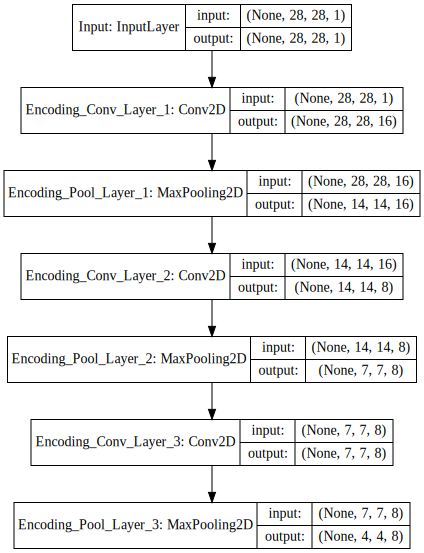

In [9]:
SVG(model_to_dot(encoder, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [10]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4, 4, 8)           0         
_________________________________________________________________
Decoding_Conv_Layer_1 (Conv2 (None, 4, 4, 8)           584       
_________________________________________________________________
Decoding_Upsampling_Layer_1  (None, 8, 8, 8)           0         
_________________________________________________________________
Decoding_Conv_Layer_2 (Conv2 (None, 8, 8, 8)           584       
_________________________________________________________________
Decoding_Upsampling_Layer_2  (None, 16, 16, 8)         0         
_________________________________________________________________
Decoding_Conv_Layer_3 (Conv2 (None, 14, 14, 16)        1168      
_________________________________________________________________
Decoding_Upsampling_Layer_3  (None, 28, 28, 16)        0         
__________

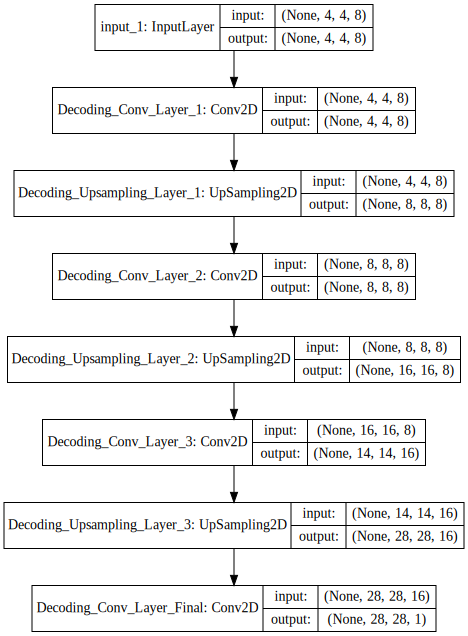

In [11]:
SVG(model_to_dot(decoder, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [12]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
Encoding_Conv_Layer_1 (Conv2 (None, 28, 28, 16)        160       
_________________________________________________________________
Encoding_Pool_Layer_1 (MaxPo (None, 14, 14, 16)        0         
_________________________________________________________________
Encoding_Conv_Layer_2 (Conv2 (None, 14, 14, 8)         1160      
_________________________________________________________________
Encoding_Pool_Layer_2 (MaxPo (None, 7, 7, 8)           0         
_________________________________________________________________
Encoding_Conv_Layer_3 (Conv2 (None, 7, 7, 8)           584       
_________________________________________________________________
Encoding_Pool_Layer_3 (MaxPo (None, 4, 4, 8)           0         
__________

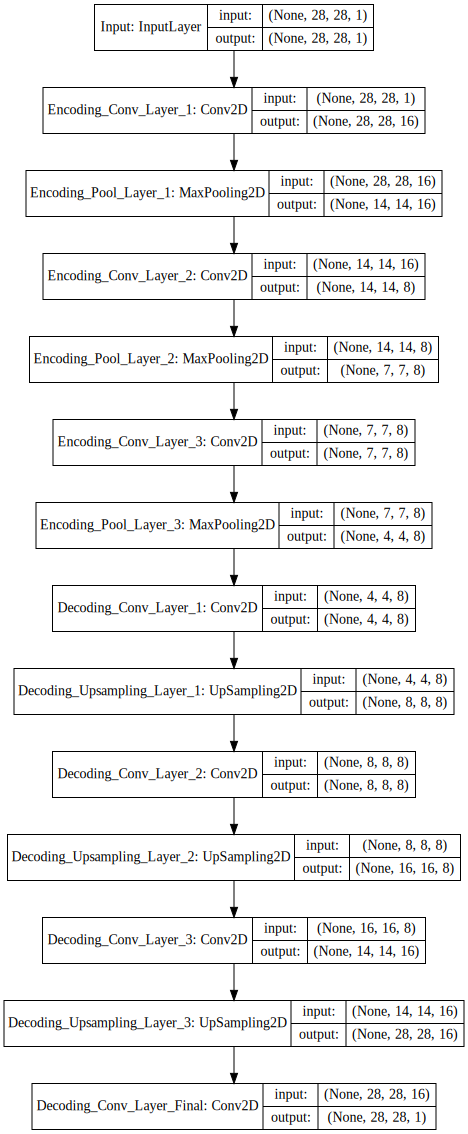

In [13]:
SVG(model_to_dot(autoencoder, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [14]:
history = autoencoder.fit(x_train, x_train, epochs = EPOCHS, batch_size = BATCH_SIZE, shuffle = True, validation_data = (x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
60000/60000 [==============================] - 8s 126us/sample - loss: 29.4788 - val_loss: 26.0367
Epoch 2/200
60000/60000 [==============================] - 3s 50us/sample - loss: 24.3811 - val_loss: 22.6061
Epoch 3/200
60000/60000 [==============================] - 3s 50us/sample - loss: 22.4560 - val_loss: 21.1692
Epoch 4/200
60000/60000 [==============================] - 3s 50us/sample - loss: 21.3004 - val_loss: 20.2438
Epoch 5/200
60000/60000 [==============================] - 3s 51us/sample - loss: 20.5820 - val_loss: 19.9996
Epoch 6/200
60000/60000 [==============================] - 3s 50us/sample - loss: 19.9830 - val_loss: 19.1833
Epoch 7/200
60000/60000 [==============================] - 3s 50us/sample - loss: 19.7853 - val_loss: 19.2886
Epoch 8/200
60000/60000 [==============================] - 3s 50us/sample - loss: 19.1806 - val_loss: 18.4178
Epoch 9/200
60000/600

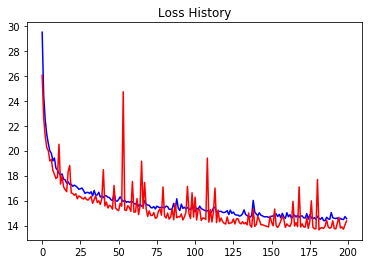

In [15]:
plt.plot(history.history['loss'], color = 'b')
plt.plot(history.history['val_loss'], color = 'r')
plt.title('Loss History')
plt.show()

In [16]:
def plot_images(nrows, figsize, image_width, image_height, image_channels, encoder, decoder):
    ncols = 3
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    plt.setp(axes.flat, xticks = [], yticks = [])
    index = randint(0, len(x_test) - 1)
    encoded_image = None
    for i, ax in enumerate(axes.flat):
        if i % 3 == 0:
            index = randint(0, len(x_test) - 1)
            ax.imshow(x_test[index].reshape(image_width, image_height), cmap = 'gray')
            ax.set_xlabel('Test_Image_' + str(index))
        elif i % 3 == 1:
            encoded_image = encoder.predict(x_test[index].reshape(1, image_width, image_height, image_channels))
            ax.imshow(encoded_image.reshape(16, 8), cmap = 'gray')
            ax.set_xlabel('Encoded_Image_' + str(index))
        elif i % 3 == 2:
            ax.imshow(decoder.predict(encoded_image).reshape(image_width, image_height), cmap = 'gray')
            ax.set_xlabel('Decoded_Image_' + str(index))
    plt.show()

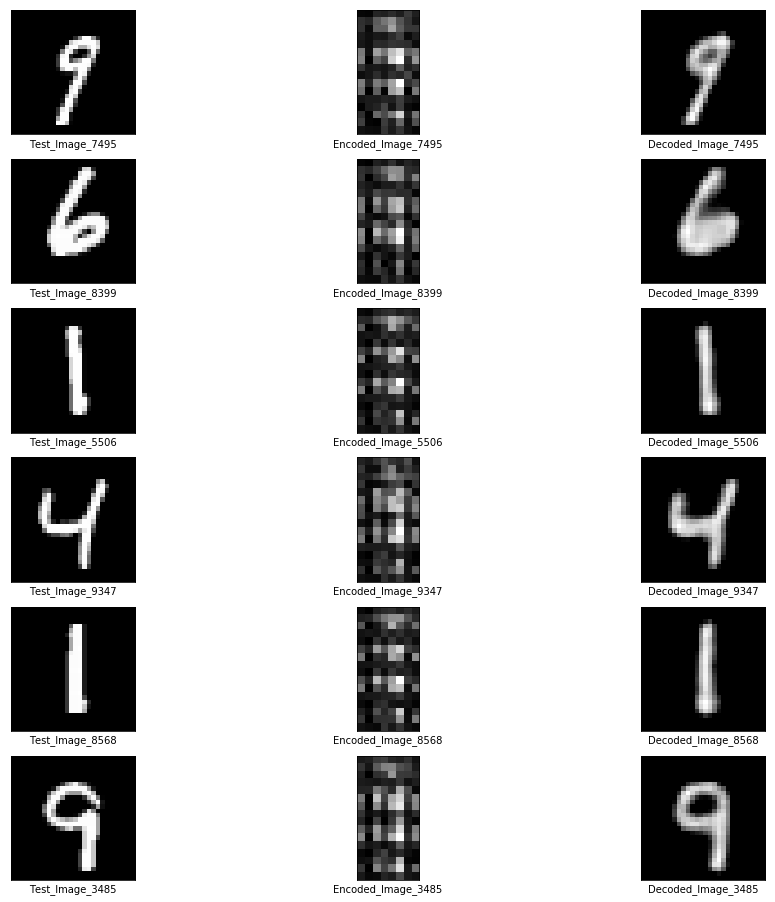

In [17]:
plot_images(6, (16, 16), IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS, encoder, decoder)

In [18]:
encoder.save('./encoder.h5')
decoder.save('./decoder.h5')